In [ ]:
import os
import time
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

from pathlib import Path
import zipfile
from zipfile import ZipFile

import cv2
from PIL import Image

import tqdm

from sklearn.model_selection import train_test_split

from typing import List, Tuple

In [ ]:
file_path = "/content/drive/MyDrive/archive.zip"
zipfile = ZipFile(file_path)
zipfile.extractall()

In [ ]:
path = "./leapGestRecog"

## Предобработка данных

In [ ]:
class_names = {}
file_counter = {}
file_img = {}

for root, dirs, files in os.walk(path):
    if dirs:
        if len(dirs[2]) > 3 and dirs[2][2] == '_':
            for dir in dirs:
                class_names[int(dir[:2])-1] = dir[3:]
                file_counter[int(dir[:2])-1] = 0
                file_img[int(dir[:2])-1] = []
            break

class_names

{0: 'palm',
 1: 'l',
 2: 'fist',
 3: 'fist_moved',
 4: 'thumb',
 5: 'index',
 6: 'ok',
 7: 'palm_moved',
 8: 'c',
 9: 'down'}

In [ ]:
file_counter

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

In [ ]:
file_img

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

In [ ]:
for root, dirs, files in os.walk(path):
    for fl in files:
        file_counter[int(fl[9:11])-1] += 1
        f = os.path.join(root, fl)
        file_img[int(fl[9:11])-1].append(f)
file_counter

{0: 2000,
 1: 2000,
 2: 2000,
 3: 2000,
 4: 2000,
 5: 2000,
 6: 2000,
 7: 2000,
 8: 2000,
 9: 2000}

In [ ]:
file_img[0][0]

'./leapGestRecog/02/01_palm/frame_02_01_0192.png'

In [ ]:
file_img[0][:5], file_img[0][-5:]

(['./leapGestRecog/02/01_palm/frame_02_01_0192.png',
  './leapGestRecog/02/01_palm/frame_02_01_0067.png',
  './leapGestRecog/02/01_palm/frame_02_01_0013.png',
  './leapGestRecog/02/01_palm/frame_02_01_0130.png',
  './leapGestRecog/02/01_palm/frame_02_01_0109.png'],
 ['./leapGestRecog/01/01_palm/frame_01_01_0173.png',
  './leapGestRecog/01/01_palm/frame_01_01_0092.png',
  './leapGestRecog/01/01_palm/frame_01_01_0040.png',
  './leapGestRecog/01/01_palm/frame_01_01_0051.png',
  './leapGestRecog/01/01_palm/frame_01_01_0046.png'])

In [ ]:
!pip install mediapipe
import mediapipe as mp

     |████████████████████████████████| 37.7MB 138kB/s 


In [ ]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
# For webcam input:
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5)

(240, 640)


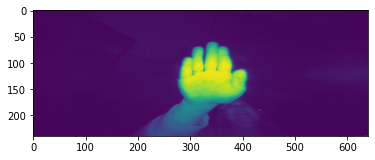

In [ ]:
img = Image.open(file_img[0][0])
print(np.asarray(img).shape)
plt.imshow(img)

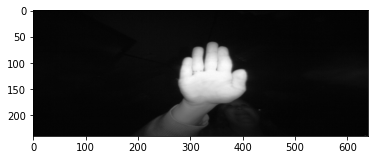

In [ ]:
src = np.asarray(img)
frame = cv2.cvtColor(src, cv2.COLOR_GRAY2RGB)
plt.imshow(frame)

In [ ]:
arm_marks = ['WRIST',
             'THUMB_CMC', 'THUMB_MCP', 'THUMB_IP', 'THUMB_TIP',
             'INDEX_FINGER_MCP', 'INDEX_FINGER_PIP', 'INDEX_FINGER_DIP', 'INDEX_FINGER_TIP',
             'MIDDLE_FINGER_MCP', 'MIDDLE_FINGER_PIP', 'MIDDLE_FINGER_DIP', 'MIDDLE_FINGER_TIP',
             'RING_FINGER_MCP', 'RING_FINGER_PIP', 'RING_FINGER_DIP', 'RING_FINGER_TIP',
             'PINKY_MCP', 'PINKY_PIP', 'PINKY_DIP', 'PINKY_TIP']

In [ ]:
def hand_detection_mp(file_pth, prn=False):
    img = np.asarray(Image.open(file_pth))
    h, w = img.shape
    frame = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)   # cv2.flip(frame, 1)

    frame.flags.writeable = False
    # im_pil = Image.fromarray(frame)
    results = hands.process(frame)
    frame.flags.writeable = True

    if results.multi_hand_landmarks and prn:
        count = 0
        for hand_landmarks in results.multi_hand_landmarks:
            count += 1
            print(f"Рука {count}")
            print(
                f'\tIndex finger tip coordinates: ('
                f'x: {round(hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * w)}, '
                f'y: {round(hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * h)})'
            )
            for num, mark in enumerate(hand_landmarks.landmark):
                print(f"\tМетка {arm_marks[num]}"
                        f"- x: {round(mark.x * w)}, y: {round(mark.y * h)}")

    return results, frame

In [ ]:
hand_detect_rez, frame = hand_detection_mp(file_img[0][0], True)

Рука 1
	Index finger tip coordinates: (x: 369, y: 81)
	Метка WRIST- x: 322, y: 168
	Метка THUMB_CMC- x: 361, y: 168
	Метка THUMB_MCP- x: 386, y: 157
	Метка THUMB_IP- x: 399, y: 138
	Метка THUMB_TIP- x: 396, y: 121
	Метка INDEX_FINGER_MCP- x: 365, y: 135
	Метка INDEX_FINGER_PIP- x: 369, y: 110
	Метка INDEX_FINGER_DIP- x: 370, y: 95
	Метка INDEX_FINGER_TIP- x: 369, y: 81
	Метка MIDDLE_FINGER_MCP- x: 341, y: 132
	Метка MIDDLE_FINGER_PIP- x: 342, y: 106
	Метка MIDDLE_FINGER_DIP- x: 344, y: 86
	Метка MIDDLE_FINGER_TIP- x: 345, y: 69
	Метка RING_FINGER_MCP- x: 319, y: 134
	Метка RING_FINGER_PIP- x: 320, y: 111
	Метка RING_FINGER_DIP- x: 322, y: 90
	Метка RING_FINGER_TIP- x: 324, y: 72
	Метка PINKY_MCP- x: 301, y: 138
	Метка PINKY_PIP- x: 298, y: 121
	Метка PINKY_DIP- x: 295, y: 105
	Метка PINKY_TIP- x: 295, y: 90


In [ ]:
# Функция рисования прямоугольников рук
def draw_hand(frame, hand_landmarks):
    h, w, _ = frame.shape
    mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    max_x = max_y = 0
    min_x = min_y = 65535
    for mark in hand_landmarks.landmark:
        if mark.x > max_x:
            max_x = mark.x
        if mark.x < min_x:
            min_x = mark.x
        if mark.y > max_y:
            max_y = mark.y
        if mark.y < min_y:
            min_y = mark.y
    max_x = round(max_x * w) + 30
    min_x = round(min_x * w) - 30
    max_y = round(max_y * h) + 30
    min_y = round(min_y * h) - 30
    if min_x < 0:
        min_x = 0
    if min_y < 0:
        min_y = 0
    if max_x > w:
        max_x = w
    if max_y > h:
        max_y = h
    print(f"\tmax_x: {max_x} min_x: {min_x} max_y: {max_y} min_y: {min_y}")
    # Рисуем обрамляющий прямоугольник руки на кадре
    cv2.rectangle(frame,
                    (min_x, min_y),
                    (max_x, max_y),
                    (0, 255, 0),
                    thickness=2)
    return frame, [min_x, min_y, max_x, max_y]

	max_x: 429 min_x: 265 max_y: 198 min_y: 39


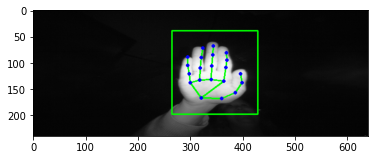

In [ ]:
if hand_detect_rez.multi_hand_landmarks:
    for hand_landmarks in hand_detect_rez.multi_hand_landmarks:
        img, hand_box = draw_hand(frame, hand_landmarks)
        plt.imshow(img)
        break

In [ ]:
# Возвращает изображение ладони
def get_hand(frame, hand_landmarks):
    h, w, _ = frame.shape
    max_x = max_y = 0
    min_x = min_y = 65535
    for mark in hand_landmarks.landmark:
        if mark.x > max_x:
            max_x = mark.x
        if mark.x < min_x:
            min_x = mark.x
        if mark.y > max_y:
            max_y = mark.y
        if mark.y < min_y:
            min_y = mark.y
    
    max_x = round(max_x * w) + 30
    min_x = round(min_x * w) - 30
    max_y = round(max_y * h) + 30
    min_y = round(min_y * h) - 30
    
    if min_x < 0:
        min_x = 0
    if min_y < 0:
        min_y = 0
    if max_x > w:
        max_x = w
    if max_y > h:
        max_y = h

    # print(f"\tmax_x: {max_x} min_x: {min_x} max_y: {max_y} min_y: {min_y}")
    
    res = frame[int(min_y):int(max_y), int(min_x):int(max_x)]
    res = cv2.resize(res, (160, 160), interpolation = cv2.INTER_AREA)
    return res

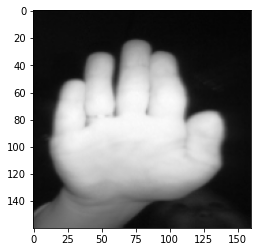

In [ ]:
hand_detect_rez, frame = hand_detection_mp(file_img[0][0])

if hand_detect_rez.multi_hand_landmarks:
    for hand_landmarks in hand_detect_rez.multi_hand_landmarks:
        img = get_hand(frame, hand_landmarks)
        plt.imshow(img)
        break

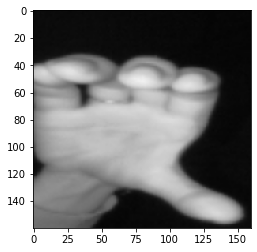

In [ ]:
hand_detect_rez, frame = hand_detection_mp(file_img[9][0])

if hand_detect_rez.multi_hand_landmarks:
    for hand_landmarks in hand_detect_rez.multi_hand_landmarks:
        img = get_hand(frame, hand_landmarks)
        plt.imshow(img)
        break

## Формирование датасета

In [ ]:
!mkdir data

In [ ]:
!ls -la

total 32
drwxr-xr-x  1 root root 4096 Jun 13 18:49 .
drwxr-xr-x  1 root root 4096 Jun 13 18:19 ..
drwxr-xr-x  4 root root 4096 Jun  1 13:40 .config
drwxr-xr-x  2 root root 4096 Jun 13 18:49 data
drwx------  5 root root 4096 Jun 13 18:48 drive
drwxr-xr-x  3 root root 4096 Jun 13 18:48 leapgestrecog
drwxr-xr-x 12 root root 4096 Jun 13 18:48 leapGestRecog
drwxr-xr-x  1 root root 4096 Jun  1 13:40 sample_data


In [ ]:
data_path = "data/"

In [ ]:
for cn in range(10):
    file_counter[cn] = 0
file_counter

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

In [ ]:
!pip install progressbar2

In [ ]:
for img in file_img[0]:
    print(img)
    print(data_path + img[-20:])   # + img[16:19]
    break

./leapGestRecog/02/01_palm/frame_02_01_0192.png
data/frame_02_01_0192.png


In [ ]:
for cn in range(10):
    have_cn_inmg = False
    for img in file_img[cn]:
        hand_detect_rez, frame = hand_detection_mp(img)
        if hand_detect_rez.multi_hand_landmarks:
            for hand_landmarks in hand_detect_rez.multi_hand_landmarks:
                image = get_hand(frame, hand_landmarks)
                path = data_path + img[-20:]   # + img[16:19]
                cv2.imwrite(path, image)
                file_counter[cn] += 1
                print(path)
                break
        break
    break

data/frame_02_01_0192.png


In [ ]:
images_data = []
labels = []
images_for_vis = []

pbar = tqdm.tqdm(total=20000)
for cn in range(10):
    have_cn_inmg = False
    for img in file_img[cn]:
        hand_detect_rez, frame = hand_detection_mp(img)
        if hand_detect_rez.multi_hand_landmarks:
            for hand_landmarks in hand_detect_rez.multi_hand_landmarks:
                image = get_hand(frame, hand_landmarks)
                path = data_path + img[-20:]   # + img[16:19]
                cv2.imwrite(path, image)
                file_counter[cn] += 1
                images_data.append(path)
                labels.append(cn)
                if not have_cn_inmg:
                    images_for_vis.append(path)
                    have_cn_inmg = True
                break
        pbar.update(1)
pbar.close()
file_counter

100%|██████████| 20000/20000 [09:27<00:00, 35.26it/s]


{0: 1973,
 1: 1135,
 2: 1201,
 3: 1182,
 4: 1248,
 5: 1062,
 6: 1841,
 7: 801,
 8: 996,
 9: 1797}

In [ ]:
len(images_data), len(labels)

(13235, 13235)

In [ ]:
images_for_vis

['data/frame_02_01_0192.png',
 'data/frame_02_02_0039.png',
 'data/frame_02_03_0197.png',
 'data/frame_02_04_0183.png',
 'data/frame_02_05_0021.png',
 'data/frame_02_06_0186.png',
 'data/frame_02_07_0109.png',
 'data/frame_02_08_0016.png',
 'data/frame_02_09_0130.png',
 'data/frame_02_10_0063.png']

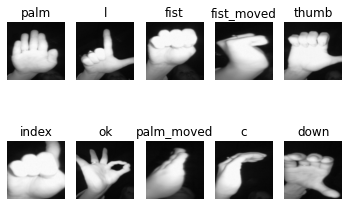

In [ ]:
# plt.figure(figsize=(10,10))
for ind in range(10):
    ax = plt.subplot(2,5,ind+1)

    img = Image.open(images_for_vis[ind])
    # hand_detect_rez, frame = hand_detection_mp(images_for_vis[ind])
    # if hand_detect_rez.multi_hand_landmarks:
    #     for hand_landmarks in hand_detect_rez.multi_hand_landmarks:
    #         img = get_hand(frame, hand_landmarks)
    #         break

    plt.imshow(img)
    plt.title(class_names[ind])
    plt.axis('off')

In [ ]:
labels[0], labels[-1]

(0, 9)

In [ ]:
data = pd.DataFrame({'images': images_data, 'labels': labels})
data.reset_index(drop=True, inplace=True)
data.tail()

,images,labels
13230,data/frame_01_10_0169.png,9
13231,data/frame_01_10_0118.png,9
13232,data/frame_01_10_0172.png,9
13233,data/frame_01_10_0026.png,9
13234,data/frame_01_10_0197.png,9


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13235 entries, 0 to 13234
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  13235 non-null  object
 1   labels  13235 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 206.9+ KB


In [ ]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info):
        # Подаем наш подготовленный датафрейм
        self.data_info = data_info
        
        self.image_arr = self.data_info.iloc[:,0]
        self.label_arr = self.data_info.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data_info.index)

    def __getitem__(self, index):
        # Читаем картинку
        img = np.asarray(Image.open(self.image_arr[index]))

        # hand_detect_rez, frame = hand_detection_mp(self.image_arr[index])
        # if hand_detect_rez.multi_hand_landmarks:
        #     for hand_landmarks in hand_detect_rez.multi_hand_landmarks:
        #         img = get_hand(frame, hand_landmarks)
        #         break

        # размер 160х160
        # Нормализуем изображение в значениях [0, 1]
        img = torch.from_numpy(img)/255   # img = torch.FloatTensor(img)
        
        img = img[:, :, 0]
        img = img.unsqueeze(0)  #.permute(2, 0, 1)   # img = img.unsqueeze(0).permute(0,3,1,2)
               
        return (img, self.label_arr[index])

    def __len__(self):
        return self.data_len

In [ ]:
# 80 % в тренировочную выборку, 20 - в валидационную
X_train, X_valid = train_test_split(data, test_size=0.2)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(X_train)   # [:300])
valid_data = CustomDatasetFromImages(X_valid)   # [:300])

In [ ]:
batch_s = 64
train_data_loader = DataLoader(train_data, batch_size=batch_s, shuffle=True)
valid_data_loader = DataLoader(valid_data, batch_size=batch_s, shuffle=True)

In [ ]:
data_iter = iter(valid_data_loader)
# [data_iter.next() for i in range(5)]
images, labels = data_iter.next()
images.shape, labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)


(torch.Size([64, 1, 160, 160]),
 tensor([8, 5, 0, 7, 3, 2, 6, 6, 7, 9, 0, 3, 5, 8, 1, 3, 5, 3, 0, 0, 4, 6, 8, 7,
         2, 8, 4, 4, 3, 5, 8, 6, 4, 5, 9, 0, 6, 5, 6, 1, 2, 4, 3, 4, 0, 7, 1, 9,
         6, 7, 7, 4, 2, 3, 7, 8, 4, 2, 3, 3, 9, 6, 9, 9]))

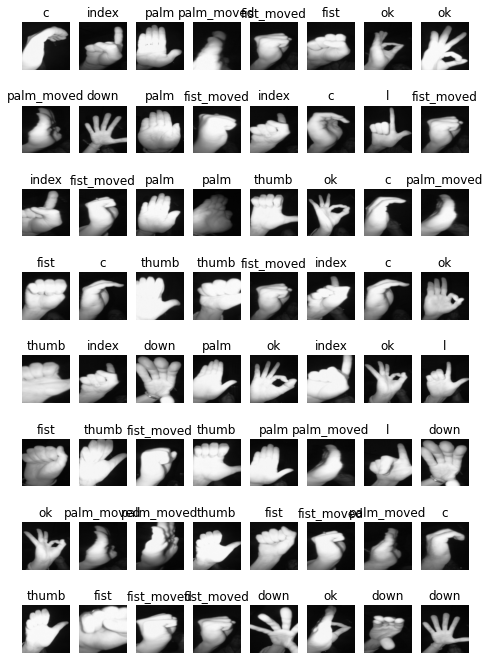

In [ ]:
plt.figure(figsize=(8,12))
for ind in range(batch_s):
    ax = plt.subplot(8,8,ind+1)
    
    plt.imshow(cv2.cvtColor(images[ind, 0, :, :].numpy(), cv2.COLOR_GRAY2RGB))
    plt.title(class_names[int(labels[ind])])
    plt.axis('off')

## Базовая модель

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [ ]:
class HPSearchNET(nn.Module):
    
    def __init__(self, 
                 cnn_num=3, 
                 fc_num=3, 
                 cnn_filt_num=16, 
                 kern_size=3, 
                 func_act='relu', 
                 in_shape=160,
                #  batch=64, 
                 nn_prn=False):
        super(HPSearchNET, self).__init__()

        self.in_size = 1
        self.cnn_num = cnn_num
        self.fc_num = fc_num
        self.cnn_filt_num = cnn_filt_num
        self.kern_size = kern_size
        self.func_act = func_act
        self.fs_size = 0
        self.in_shape = in_shape
        # self.batch = batch
        self.nn_prn = nn_prn
        
        if kern_size == 3:
            padd = (1, 1)
        if kern_size == 5:
            padd = (2, 2)
        
        if func_act == 'relu':
            self.str_f_act = nn.ReLU()
        else:
            self.str_f_act = nn.ELU()
        self.sftmx = nn.Softmax(dim = 1)

        self.conv1 = nn.Conv2d(self.in_size, 
                               self.cnn_filt_num, 
                               kernel_size=self.kern_size, 
                               stride=1, 
                               padding=padd)
        self.pool = nn.MaxPool2d(2, 2)
        if self.cnn_num > 1:
            self.conv2 = nn.Conv2d(self.cnn_filt_num, 
                                   self.cnn_filt_num*2, 
                                   kernel_size=self.kern_size, 
                                   stride=1, 
                                   padding=padd)
            self.cnn_filt_num *= 2
            if self.cnn_num > 2:
                self.conv3 = nn.Conv2d(self.cnn_filt_num, 
                                       self.cnn_filt_num*2, 
                                       kernel_size=self.kern_size, 
                                       stride=1, 
                                       padding=padd)
                self.cnn_filt_num *= 2
        
        self.fs_size = self.cnn_filt_num * (self.in_shape//2**self.cnn_num) ** 2
        fs_sz = self.fs_size
        
        if self.fc_num > 2:
            self.fc_dec2 = nn.Linear(fs_sz, fs_sz//4)   # fs_sz*3//4
            fs_sz=fs_sz//4   #*3//4
        if self.fc_num > 1:
            self.fc_dec1 = nn.Linear(fs_sz, fs_sz//4)   # fs_sz*3//4
            fs_sz=fs_sz//4   # *3//4
        self.fc_out = nn.Linear(fs_sz, 10)

    def forward(self, x):
        if self.nn_prn:
            if self.func_act == 'relu':
                print("\n\tФункции активации ReLU")
            else:
                print("\n\tФункции активации ELU")
            print("\n\tX размеры income: %s" % (x.shape,))
        x = self.pool(self.str_f_act(self.conv1(x)))
        if self.nn_prn:
            print("\tX размеры conv1, pool: %s" % (x.shape,))
        if self.cnn_num > 1:
            x = self.pool(self.str_f_act(self.conv2(x)))
            if self.nn_prn:
                print("\tX размеры conv2, pool: %s" % (x.shape,))
            if self.cnn_num > 2:
                x = self.pool(self.str_f_act(self.conv3(x)))
                if self.nn_prn:
                    print("\tX размеры conv3, pool: %s" % (x.shape,))
        x = x.view(-1, self.fs_size)
        if self.nn_prn:
            print("\tX размеры x.view: %s" % (x.shape,))
        if self.fc_num > 2:
            x = self.str_f_act(self.fc_dec2(x))
            if self.nn_prn:
                print("\tX размеры fc_dec2: %s" % (x.shape,))
        if self.fc_num > 1:
            x = self.str_f_act(self.fc_dec1(x))
            if self.nn_prn:
                print("\tX размеры fc_dec1: %s" % (x.shape,))
        x = self.sftmx(self.fc_out(x))
        if self.nn_prn:
            print("\tX размеры fc_out: %s\n" % (x.shape,))
            self.nn_prn = False
        return x

In [ ]:
model = HPSearchNET(nn_prn=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
epochs = 10
path_checkpoint = "checkpoints"
if not os.path.exists(path_checkpoint):
    os.mkdir(path_checkpoint)


epoch_losses = []
epoch_val_losses = []

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    cum_loss = []

    print(f'Epoch: {epoch+1}')
    time1 = time.time()
    model.train()
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device) # .cuda()
        labels = labels.to(device) # .cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        cum_loss.append(loss.item())
        bundle = 20
        if not (i+1) % bundle:    # print every 10 mini-batches
            print(f'\tbatchcount: {i+1}, size: {batch_s*bundle} '
                  f'total: {(i+1)*batch_s} '
                  f'loss: {running_loss/(batch_s*bundle):.5f}')
            running_loss = 0.0

    time2 = time.time()
    epoch_losses.append(np.mean(cum_loss))
    torch.save(model.state_dict(), path_checkpoint + f"/checkpoint_ep_{epoch}.pth")

    cum_loss = []
    model.eval()
    with torch.no_grad():
        running_val_loss = 0.0
        for i, data in enumerate(valid_data_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device) # .cuda()
            labels = labels.to(device) # .cuda()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()
            cum_loss.append(loss.item())

    epoch_val_losses.append(np.mean(cum_loss))
    print(f'\n  Epoch {epoch+1}, loss: {epoch_losses[-1]:.5f} loss_val: {epoch_val_losses[-1]:.5f} time = {time2-time1:.2f} sec\n')

Epoch: 1

	Функции активации ReLU

	X размеры income: torch.Size([64, 1, 160, 160])
	X размеры conv1, pool: torch.Size([64, 16, 80, 80])
	X размеры conv2, pool: torch.Size([64, 32, 40, 40])
	X размеры conv3, pool: torch.Size([64, 64, 20, 20])
	X размеры x.view: torch.Size([64, 25600])
	X размеры fc_dec2: torch.Size([64, 6400])
	X размеры fc_dec1: torch.Size([64, 1600])
	X размеры fc_out: torch.Size([64, 10])

	batchcount: 20, size: 1280 total: 1280 loss: 0.03597
	batchcount: 40, size: 1280 total: 2560 loss: 0.03596
	batchcount: 60, size: 1280 total: 3840 loss: 0.03596
	batchcount: 80, size: 1280 total: 5120 loss: 0.03595
	batchcount: 100, size: 1280 total: 6400 loss: 0.03594
	batchcount: 120, size: 1280 total: 7680 loss: 0.03594
	batchcount: 140, size: 1280 total: 8960 loss: 0.03593
	batchcount: 160, size: 1280 total: 10240 loss: 0.03591

  Epoch 1, loss: 2.30039 loss_val: 2.29743 time = 21.09 sec

Epoch: 2
	batchcount: 20, size: 1280 total: 1280 loss: 0.03588
	batchcount: 40, size: 12

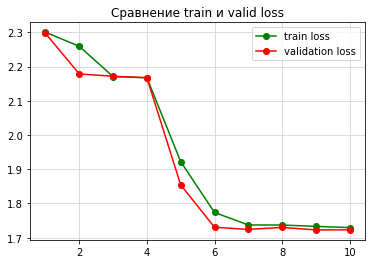

In [ ]:
plt.plot(np.arange(1, epochs+1), epoch_losses, 'go-', label='train loss')
plt.plot(np.arange(1, epochs+1), epoch_val_losses, 'ro-', label='validation loss')

plt.legend(loc="upper right")
plt.grid(color="lightgrey")
plt.title('Сравнение train и valid loss' )
plt.show()

## Подбор гиперпараметров

In [ ]:
class HyperParSearch:
    
    def __init__(self):
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.net = None
        self.summary_data = pd.DataFrame(data=[[0, 0, 0, 0, 0, 0, 0, 0]], 
                            columns=['func', 'cnn_num', 
                                     'fc_num', 'kern_size', 
                                     'loss', 'accuracy', 
                                     'loss_val', 'accuracy_val'])
        self.cnn_num = [2, 3]
        self.fc_num = [2, 3]
        self.kern_size = [3, 5]
        self.func_act = ['relu', 'elu']
        self.epochs = 5
        self.in_shape = 160

    def net_sample(self):
        if self.net == None:
            return 0
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.net.parameters(), 
                                    lr=0.01,   # lr=0.001
                                    momentum=0.9)
        ep_loss_list = []
        ep_acc_list = []
        for epoch in range(self.epochs):
            time1 = time.time()
            self.net.train()
            
            total_loss = 0
            loss_list = []
            acc_list = []
            epoch_val_losses = []
            epoch_val_acc = []
            running_loss = 0.0
            
            for i, data in enumerate(train_data_loader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # обнуляем градиент
                optimizer.zero_grad()

                outputs = self.net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                bundle = 20
                if not (i+1) % bundle:    # print every 10 mini-batches
                    print(f'\t\t\tbatchcount: {i+1}, size: {batch_s*bundle} '
                          f'total: {(i+1)*batch_s} '
                          f'loss: {running_loss/(batch_s*bundle):.5f}')
                    running_loss = 0.0

                # выводим статистику о процессе обучения
                loss_list.append(loss.item())

                # Отслеживание точности
                total = labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct = (predicted == labels).sum().item()
                acc_list.append(correct / total)
                
            ep_loss_list.append(sum(loss_list) / len(loss_list))
            ep_acc_list.append(sum(acc_list) / len(acc_list))

            time2 = time.time()
            cum_loss = []
            cum_acc = []
            self.net.eval()
            with torch.no_grad():
                running_val_loss = 0.0
                for i, data in enumerate(valid_data_loader, 0):
                    inputs, labels = data
                    inputs, labels = inputs.to(self.device), labels.to(self.device)

                    outputs = self.net(inputs)
                    loss = criterion(outputs, labels)

                    running_val_loss += loss.item()
                    cum_loss.append(loss.item())

                    # Отслеживание точности
                    total = labels.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    correct = (predicted == labels).sum().item()
                    cum_acc.append(correct / total)

            epoch_val_losses.append(np.mean(cum_loss))
            epoch_val_acc.append(np.mean(cum_acc))
            print(f"\t\tЭпоха: {epoch+1}   loss: {ep_loss_list[-1]:.5f}   "
                  f"accuracy: {ep_acc_list[-1]*100:.3f}%   "
                  f"loss_val: {epoch_val_losses[-1]:.5f}   "
                  f"accuracy_val: {epoch_val_acc[-1]*100:.3f}%   "
                  f"time = {time2-time1:.2f} c")

        return ep_loss_list, ep_acc_list, epoch_val_losses, epoch_val_acc
        
    def grid_search(self):
        cnt = 0
        
        path_dir = './net'
        if not os.path.exists(path_dir):
            os.mkdir(path_dir)
        
        for f_a in self.func_act:
            for c_n in self.cnn_num:
                for f_n in self.fc_num:
                    for k_s in self.kern_size:
                        loss_m = []
                        acc_m = []
                        print(f"Модель: функция активации: {f_a}, cnn слоёв: {c_n}, fc слоёв: {f_n}, kernel: {k_s}\n")
                        self.net = HPSearchNET(cnn_num=c_n, 
                                               fc_num=f_n, 
                                               kern_size=k_s, 
                                               func_act=f_a, 
                                               nn_prn=True,
                                               in_shape=self.in_shape).to(self.device)
                        print("\tМодель state_dict: ")
                        for param in self.net.state_dict():
                            print("\t\t", param,": ", self.net.state_dict()[param].size())

                        loss, acc, loss_val, acc_val = self.net_sample()
                        torch.save(self.net.state_dict(), f'./net/cifar_net_{f_a}_cnn{c_n}_fc{f_n}_kr{k_s}.pth')

                        print(f"\tLoss на train: {loss[-1]:.5f}   accuracy на train: {acc[-1]:.5f}")
                        print(f"\tLoss на valid: {loss_val[-1]:.5f}   accuracy на valid: {acc_val[-1]:.5f}\n")
                        self.summary_data.loc[cnt, ['func', 'cnn_num', 'fc_num', 'kern_size', 
                                                    'loss', 'accuracy', 'loss_val', 'accuracy_val']] = [f_a, c_n, 
                                                    f_n, k_s, loss[-1], acc[-1], loss_val[-1], acc_val[-1]]
                        cnt += 1

In [ ]:
search_top = HyperParSearch()
search_top.grid_search()

Модель: функция активации: relu, cnn слоёв: 2, fc слоёв: 2, kernel: 3

	Модель state_dict: 
		 conv1.weight :  torch.Size([16, 1, 3, 3])
		 conv1.bias :  torch.Size([16])
		 conv2.weight :  torch.Size([32, 16, 3, 3])
		 conv2.bias :  torch.Size([32])
		 fc_dec1.weight :  torch.Size([12800, 51200])
		 fc_dec1.bias :  torch.Size([12800])
		 fc_out.weight :  torch.Size([10, 12800])
		 fc_out.bias :  torch.Size([10])

	Функции активации ReLU

	X размеры income: torch.Size([64, 1, 160, 160])
	X размеры conv1, pool: torch.Size([64, 16, 80, 80])
	X размеры conv2, pool: torch.Size([64, 32, 40, 40])
	X размеры x.view: torch.Size([64, 51200])
	X размеры fc_dec1: torch.Size([64, 12800])
	X размеры fc_out: torch.Size([64, 10])

			batchcount: 20, size: 1280 total: 1280 loss: 0.03587
			batchcount: 40, size: 1280 total: 2560 loss: 0.03540
			batchcount: 60, size: 1280 total: 3840 loss: 0.03476
			batchcount: 80, size: 1280 total: 5120 loss: 0.03270
			batchcount: 100, size: 1280 total: 6400 loss: 0

In [ ]:
search_top.summary_data

,func,cnn_num,fc_num,kern_size,loss,accuracy,loss_val,accuracy_val
0,relu,2.0,2.0,3.0,1.570549,0.890867,1.566373,0.894378
1,relu,2.0,2.0,5.0,1.588710,0.873037,1.560323,0.900993
2,relu,2.0,3.0,3.0,1.580152,0.881952,1.573127,0.890043
3,relu,2.0,3.0,5.0,1.650711,0.810443,1.647412,0.814975
4,relu,3.0,2.0,3.0,1.580534,0.880849,1.574561,0.887228
5,relu,3.0,2.0,5.0,1.641557,0.819116,1.625963,0.834983
6,relu,3.0,3.0,3.0,1.743509,0.717594,1.735144,0.724363
7,relu,3.0,3.0,5.0,1.662543,0.798233,1.644801,0.815217
8,elu,2.0,2.0,3.0,1.486780,0.976657,1.480272,0.982515
9,elu,2.0,2.0,5.0,1.568261,0.894202,1.561779,0.900378


In [ ]:
search_top.summary_data.sort_values('accuracy_val', ascending=False)

,func,cnn_num,fc_num,kern_size,loss,accuracy,loss_val,accuracy_val
8,elu,2.0,2.0,3.0,1.486780,0.976657,1.480272,0.982515
13,elu,3.0,2.0,5.0,1.556906,0.904314,1.552610,0.907900
12,elu,3.0,2.0,3.0,1.560293,0.901678,1.556613,0.905296
15,elu,3.0,3.0,5.0,1.563216,0.898639,1.559515,0.902400
1,relu,2.0,2.0,5.0,1.588710,0.873037,1.560323,0.900993
9,elu,2.0,2.0,5.0,1.568261,0.894202,1.561779,0.900378
10,elu,2.0,3.0,3.0,1.562775,0.898801,1.568035,0.896658
0,relu,2.0,2.0,3.0,1.570549,0.890867,1.566373,0.894378
14,elu,3.0,3.0,3.0,1.563164,0.898975,1.568291,0.893100
2,relu,2.0,3.0,3.0,1.580152,0.881952,1.573127,0.890043


## Итоговое обучение

In [ ]:
def fit_rez(model, epochs, path_checkpoint, shed=False):

    if not os.path.exists(path_checkpoint):
        os.mkdir(path_checkpoint)

    epoch_losses = []
    epoch_acc = []
    epoch_val_losses = []
    epoch_val_acc = []
    bundle = 20

    print("State_dict модели: ")
    for param in model.state_dict():
        print("\t", param,": ", model.state_dict()[param].size())

    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        cum_loss = []
        cum_acc = []

        # print(f'Эпоха: {epoch+1}')
        time1 = time.time()
        model.train()
        for i, data in enumerate(train_data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if shed:
                scheduler.step()

            cum_loss.append(loss.item())

            # print statistics
            # running_loss += loss.item()
            # if not (i+1) % bundle:    # print every 10 mini-batches
            #     print(f'\tbatchcount: {i+1}, size: {batch_s*bundle} '
            #         f'total: {(i+1)*batch_s} '
            #         f'loss: {running_loss/(batch_s*bundle):.5f}')
            #     running_loss = 0.0

            # Отслеживание точности
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            cum_acc.append(correct / total)

        time2 = time.time()
        epoch_losses.append(np.mean(cum_loss))
        epoch_acc.append(np.mean(cum_acc))
        if epoch > 4:
            torch.save(model.state_dict(), path_checkpoint + f"/checkpoint_ep_{epoch+1}.pth")

        cum_loss = []
        cum_acc = []
        model.eval()
        with torch.no_grad():
            running_val_loss = 0.0
            for i, data in enumerate(valid_data_loader, 0):
                inputs, labels = data
                inputs = inputs.to(device) # .cuda()
                labels = labels.to(device) # .cuda()

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                cum_loss.append(loss.item())

                # Отслеживание точности
                total = labels.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct = (predicted == labels).sum().item()
                cum_acc.append(correct / total)

        epoch_val_losses.append(np.mean(cum_loss))
        epoch_val_acc.append(np.mean(cum_acc))
        print(f"Эпоха: {epoch+1}   loss: {epoch_losses[-1]:.5f}   "
              f"accuracy: {epoch_acc[-1]*100:.3f}%   "
              f"loss_val: {epoch_val_losses[-1]:.5f}   "
              f"accuracy_val: {epoch_val_acc[-1]*100:.3f}%   "
              f"time = {time2-time1:.2f} c")
        
    return {"epoch_losses": epoch_losses, 
            "epoch_val_losses": epoch_val_losses, 
            "epoch_acc": epoch_acc, 
            "epoch_val_acc": epoch_val_acc}

In [ ]:
def graph(hist):
    plt.figure(figsize=(12, 4))
    ax = plt.subplot(1, 2, 1)

    len_l = len(hist["epoch_losses"])

    plt.plot(np.arange(1, len_l + 1), hist["epoch_losses"], 'go-', label='train loss')
    plt.plot(np.arange(1, len_l + 1), hist["epoch_val_losses"], 'ro-', label='validation loss')

    plt.legend(loc="upper right")
    plt.grid(color="lightgrey")
    plt.title('Сравнение train и valid loss')

    ax = plt.subplot(1, 2, 2)

    plt.plot(np.arange(1, len_l + 1), hist["epoch_acc"], 'go-', label='train accuracy')
    plt.plot(np.arange(1, len_l + 1), hist["epoch_val_acc"], 'ro-', label='validation accuracy')

    plt.legend(loc="lower right")
    plt.grid(color="lightgrey")
    plt.title('Сравнение train и valid accuracy')
    plt.show()

In [ ]:
epochs = 12
lr = 0.001

In [ ]:
model = HPSearchNET(cnn_num=3, 
                    fc_num=3, 
                    kern_size=5, 
                    func_act='elu', 
                    nn_prn=True,
                    in_shape=160).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [ ]:
hist_st = fit_rez(model, epochs, "rez_checkpoints_st_sgd_lr001_nosh")

State_dict модели: 
	 conv1.weight :  torch.Size([16, 1, 5, 5])
	 conv1.bias :  torch.Size([16])
	 conv2.weight :  torch.Size([32, 16, 5, 5])
	 conv2.bias :  torch.Size([32])
	 conv3.weight :  torch.Size([64, 32, 5, 5])
	 conv3.bias :  torch.Size([64])
	 fc_dec2.weight :  torch.Size([6400, 25600])
	 fc_dec2.bias :  torch.Size([6400])
	 fc_dec1.weight :  torch.Size([1600, 6400])
	 fc_dec1.bias :  torch.Size([1600])
	 fc_out.weight :  torch.Size([10, 1600])
	 fc_out.bias :  torch.Size([10])

	Функции активации ELU

	X размеры income: torch.Size([64, 1, 160, 160])
	X размеры conv1, pool: torch.Size([64, 16, 80, 80])
	X размеры conv2, pool: torch.Size([64, 32, 40, 40])
	X размеры conv3, pool: torch.Size([64, 64, 20, 20])
	X размеры x.view: torch.Size([64, 25600])
	X размеры fc_dec2: torch.Size([64, 6400])
	X размеры fc_dec1: torch.Size([64, 1600])
	X размеры fc_out: torch.Size([64, 10])

Эпоха: 1   loss: 2.29970   accuracy: 15.696%   loss_val: 2.29551   accuracy_val: 15.027%   time = 21.84

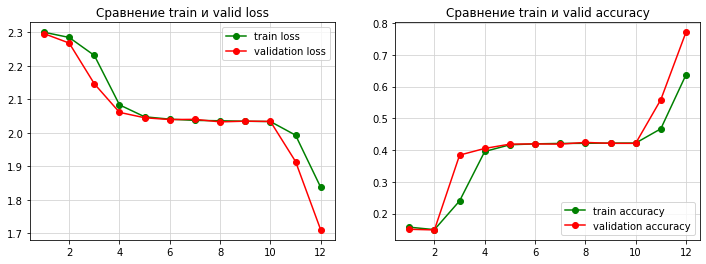

In [ ]:
graph(hist_st)

In [ ]:
epochs = 5
lr = 0.005

model = HPSearchNET(cnn_num=3, 
                    fc_num=3, 
                    kern_size=5, 
                    func_act='elu', 
                    nn_prn=True,
                    in_shape=160).to(device)

criterion = nn.CrossEntropyLoss()

# weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr)   # , weight_decay=weight_decay


hist_st_adam = fit_rez(model, epochs, "rez_checkpoints_st_sgd_lr005_nosh")

State_dict модели: 
	 conv1.weight :  torch.Size([16, 1, 5, 5])
	 conv1.bias :  torch.Size([16])
	 conv2.weight :  torch.Size([32, 16, 5, 5])
	 conv2.bias :  torch.Size([32])
	 conv3.weight :  torch.Size([64, 32, 5, 5])
	 conv3.bias :  torch.Size([64])
	 fc_dec2.weight :  torch.Size([6400, 25600])
	 fc_dec2.bias :  torch.Size([6400])
	 fc_dec1.weight :  torch.Size([1600, 6400])
	 fc_dec1.bias :  torch.Size([1600])
	 fc_out.weight :  torch.Size([10, 1600])
	 fc_out.bias :  torch.Size([10])

	Функции активации ELU

	X размеры income: torch.Size([64, 1, 160, 160])
	X размеры conv1, pool: torch.Size([64, 16, 80, 80])
	X размеры conv2, pool: torch.Size([64, 32, 40, 40])
	X размеры conv3, pool: torch.Size([64, 64, 20, 20])
	X размеры x.view: torch.Size([64, 25600])
	X размеры fc_dec2: torch.Size([64, 6400])
	X размеры fc_dec1: torch.Size([64, 1600])
	X размеры fc_out: torch.Size([64, 10])

Эпоха: 1   loss: 2.36777   accuracy: 9.277%   loss_val: 2.36153   accuracy_val: 9.962%   time = 24.75 c

In [ ]:
epochs = 12
lr = 0.01

model = HPSearchNET(cnn_num=3, 
                    fc_num=3, 
                    kern_size=5, 
                    func_act='elu', 
                    nn_prn=True,
                    in_shape=160).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                lr, 
                                                epochs=epochs, 
                                                steps_per_epoch=len(train_data_loader))

hist_st_adam = fit_rez(model, epochs, "rez_checkpoints_st_sgd_lr01_OneCycleLR", shed=True)

State_dict модели: 
	 conv1.weight :  torch.Size([16, 1, 5, 5])
	 conv1.bias :  torch.Size([16])
	 conv2.weight :  torch.Size([32, 16, 5, 5])
	 conv2.bias :  torch.Size([32])
	 conv3.weight :  torch.Size([64, 32, 5, 5])
	 conv3.bias :  torch.Size([64])
	 fc_dec2.weight :  torch.Size([6400, 25600])
	 fc_dec2.bias :  torch.Size([6400])
	 fc_dec1.weight :  torch.Size([1600, 6400])
	 fc_dec1.bias :  torch.Size([1600])
	 fc_out.weight :  torch.Size([10, 1600])
	 fc_out.bias :  torch.Size([10])

	Функции активации ELU

	X размеры income: torch.Size([64, 1, 160, 160])
	X размеры conv1, pool: torch.Size([64, 16, 80, 80])
	X размеры conv2, pool: torch.Size([64, 32, 40, 40])
	X размеры conv3, pool: torch.Size([64, 64, 20, 20])
	X размеры x.view: torch.Size([64, 25600])
	X размеры fc_dec2: torch.Size([64, 6400])
	X размеры fc_dec1: torch.Size([64, 1600])
	X размеры fc_out: torch.Size([64, 10])

Эпоха: 1   loss: 2.29996   accuracy: 14.026%   loss_val: 2.29178   accuracy_val: 15.093%   time = 22.19

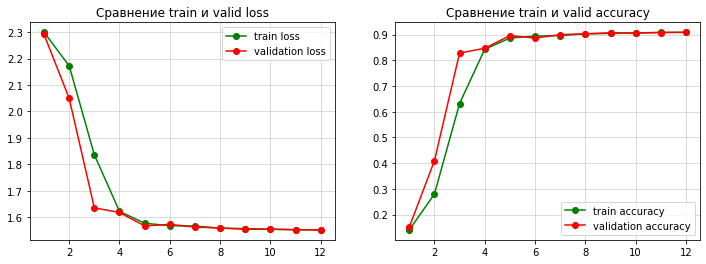

In [ ]:
graph(hist_st_adam)

In [ ]:
epochs = 20
lr = 0.001

model = HPSearchNET(cnn_num=3, 
                    fc_num=3, 
                    kern_size=5, 
                    func_act='elu', 
                    nn_prn=True,
                    in_shape=160).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                lr, 
                                                epochs=epochs, 
                                                steps_per_epoch=len(train_data_loader))


hist_st_001 = fit_rez(model, epochs, "rez_checkpoints_st_sgd_lr001_OneCycleLR", shed=True)

State_dict модели: 
	 conv1.weight :  torch.Size([16, 1, 5, 5])
	 conv1.bias :  torch.Size([16])
	 conv2.weight :  torch.Size([32, 16, 5, 5])
	 conv2.bias :  torch.Size([32])
	 conv3.weight :  torch.Size([64, 32, 5, 5])
	 conv3.bias :  torch.Size([64])
	 fc_dec2.weight :  torch.Size([6400, 25600])
	 fc_dec2.bias :  torch.Size([6400])
	 fc_dec1.weight :  torch.Size([1600, 6400])
	 fc_dec1.bias :  torch.Size([1600])
	 fc_out.weight :  torch.Size([10, 1600])
	 fc_out.bias :  torch.Size([10])

	Функции активации ELU

	X размеры income: torch.Size([64, 1, 160, 160])
	X размеры conv1, pool: torch.Size([64, 16, 80, 80])
	X размеры conv2, pool: torch.Size([64, 32, 40, 40])
	X размеры conv3, pool: torch.Size([64, 64, 20, 20])
	X размеры x.view: torch.Size([64, 25600])
	X размеры fc_dec2: torch.Size([64, 6400])
	X размеры fc_dec1: torch.Size([64, 1600])
	X размеры fc_out: torch.Size([64, 10])

Эпоха: 1   loss: 2.30215   accuracy: 10.495%   loss_val: 2.30160   accuracy_val: 15.555%   time = 22.04

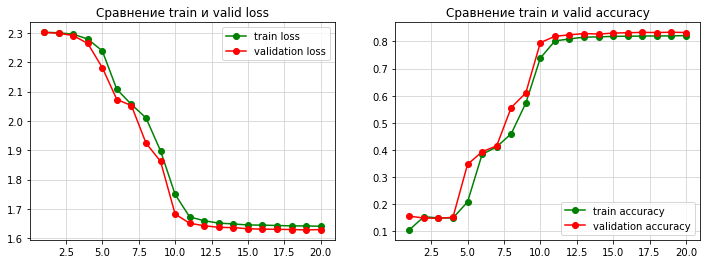

In [ ]:
graph(hist_st_001)

In [ ]:
epochs = 12
lr = 0.01

model = HPSearchNET(cnn_num=3, 
                    fc_num=2, 
                    kern_size=5, 
                    func_act='elu', 
                    nn_prn=True,
                    in_shape=160).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                lr, 
                                                epochs=epochs, 
                                                steps_per_epoch=len(train_data_loader))

hist_md325_01 = fit_rez(model, epochs, "rez_checkpoints_md325_sgd_lr01_OneCycleLR", shed=True)

State_dict модели: 
	 conv1.weight :  torch.Size([16, 1, 5, 5])
	 conv1.bias :  torch.Size([16])
	 conv2.weight :  torch.Size([32, 16, 5, 5])
	 conv2.bias :  torch.Size([32])
	 conv3.weight :  torch.Size([64, 32, 5, 5])
	 conv3.bias :  torch.Size([64])
	 fc_dec1.weight :  torch.Size([6400, 25600])
	 fc_dec1.bias :  torch.Size([6400])
	 fc_out.weight :  torch.Size([10, 6400])
	 fc_out.bias :  torch.Size([10])

	Функции активации ELU

	X размеры income: torch.Size([64, 1, 160, 160])
	X размеры conv1, pool: torch.Size([64, 16, 80, 80])
	X размеры conv2, pool: torch.Size([64, 32, 40, 40])
	X размеры conv3, pool: torch.Size([64, 64, 20, 20])
	X размеры x.view: torch.Size([64, 25600])
	X размеры fc_dec1: torch.Size([64, 6400])
	X размеры fc_out: torch.Size([64, 10])

Эпоха: 1   loss: 2.26931   accuracy: 17.489%   loss_val: 2.11044   accuracy_val: 37.497%   time = 21.97 c
Эпоха: 2   loss: 1.89514   accuracy: 57.047%   loss_val: 1.79912   accuracy_val: 65.289%   time = 21.86 c
Эпоха: 3   loss:

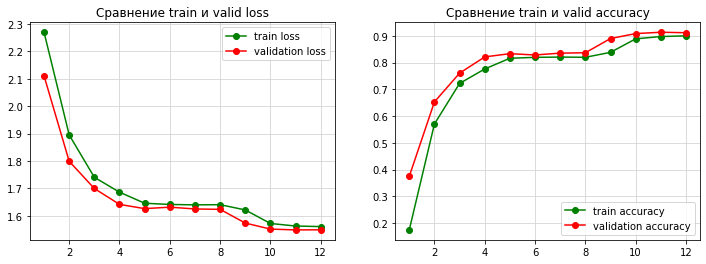

In [ ]:
graph(hist_md325_01)

In [ ]:
epochs = 12
lr = 0.01

model = HPSearchNET(cnn_num=2, 
                    fc_num=3, 
                    kern_size=5, 
                    func_act='elu', 
                    nn_prn=True,
                    in_shape=160).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                lr, 
                                                epochs=epochs, 
                                                steps_per_epoch=len(train_data_loader))


hist_md235_01 = fit_rez(model, epochs, "rez_checkpoints_md235_sgd_lr01_OneCycleLR", shed=True)

State_dict модели: 
	 conv1.weight :  torch.Size([16, 1, 5, 5])
	 conv1.bias :  torch.Size([16])
	 conv2.weight :  torch.Size([32, 16, 5, 5])
	 conv2.bias :  torch.Size([32])
	 fc_dec2.weight :  torch.Size([12800, 51200])
	 fc_dec2.bias :  torch.Size([12800])
	 fc_dec1.weight :  torch.Size([3200, 12800])
	 fc_dec1.bias :  torch.Size([3200])
	 fc_out.weight :  torch.Size([10, 3200])
	 fc_out.bias :  torch.Size([10])

	Функции активации ELU

	X размеры income: torch.Size([64, 1, 160, 160])
	X размеры conv1, pool: torch.Size([64, 16, 80, 80])
	X размеры conv2, pool: torch.Size([64, 32, 40, 40])
	X размеры x.view: torch.Size([64, 51200])
	X размеры fc_dec2: torch.Size([64, 12800])
	X размеры fc_dec1: torch.Size([64, 3200])
	X размеры fc_out: torch.Size([64, 10])

Эпоха: 1   loss: 2.25153   accuracy: 19.793%   loss_val: 2.09986   accuracy_val: 38.477%   time = 36.23 c
Эпоха: 2   loss: 1.86853   accuracy: 60.291%   loss_val: 1.67623   accuracy_val: 79.273%   time = 33.25 c
Эпоха: 3   loss: 1

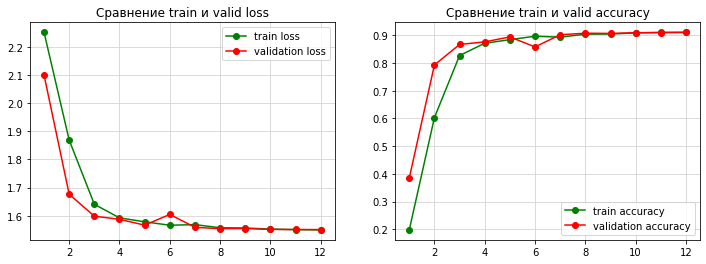

In [ ]:
graph(hist_md235_01)

In [ ]:
def model_loaded_test(model):
    epoch_losses = 0
    epoch_acc = 0
    epoch_val_losses = 0
    epoch_val_acc = 0
    
    model.eval()

    print("State_dict модели: ")
    for param in model.state_dict():
        print("\t", param,": ", model.state_dict()[param].size())

    with torch.no_grad():
        cum_loss = []
        cum_acc = []

        for i, data in enumerate(train_data_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            cum_loss.append(loss.item())

            # Отслеживание точности
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            cum_acc.append(correct / total)

        epoch_losses = np.mean(cum_loss)
        epoch_acc = np.mean(cum_acc)
            
        cum_loss = []
        cum_acc = []
        for i, data in enumerate(valid_data_loader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            cum_loss.append(loss.item())

            # Отслеживание точности
            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            cum_acc.append(correct / total)

        epoch_val_losses = np.mean(cum_loss)
        epoch_val_acc = np.mean(cum_acc)
        print(f"Модель - loss: {epoch_losses:.5f}   "
              f"accuracy: {epoch_acc*100:.3f}%   "
              f"loss_val: {epoch_val_losses:.5f}   "
              f"accuracy_val: {epoch_val_acc*100:.3f}%")

In [ ]:
epochs = 18
lr = 0.01

model_ln = HPSearchNET(cnn_num=3, 
                       fc_num=2, 
                       kern_size=3, 
                       func_act='elu', 
                       nn_prn=True,
                       in_shape=160).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ln.parameters(), lr=lr, momentum=0.9)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
#                                                 lr, 
#                                                 epochs=epochs, 
#                                                 steps_per_epoch=len(train_data_loader))

hist_md323_01 = fit_rez(model_ln, epochs, "rez_checkpoints_md323_sgd_lr01_OneCycleLR")   # , shed=True)

State_dict модели: 
	 conv1.weight :  torch.Size([16, 1, 3, 3])
	 conv1.bias :  torch.Size([16])
	 conv2.weight :  torch.Size([32, 16, 3, 3])
	 conv2.bias :  torch.Size([32])
	 conv3.weight :  torch.Size([64, 32, 3, 3])
	 conv3.bias :  torch.Size([64])
	 fc_dec1.weight :  torch.Size([6400, 25600])
	 fc_dec1.bias :  torch.Size([6400])
	 fc_out.weight :  torch.Size([10, 6400])
	 fc_out.bias :  torch.Size([10])

	Функции активации ELU

	X размеры income: torch.Size([64, 1, 160, 160])
	X размеры conv1, pool: torch.Size([64, 16, 80, 80])
	X размеры conv2, pool: torch.Size([64, 32, 40, 40])
	X размеры conv3, pool: torch.Size([64, 64, 20, 20])
	X размеры x.view: torch.Size([64, 25600])
	X размеры fc_dec1: torch.Size([64, 6400])
	X размеры fc_out: torch.Size([64, 10])

Эпоха: 1   loss: 2.13540   accuracy: 32.342%   loss_val: 2.03816   accuracy_val: 41.913%   time = 20.63 c
Эпоха: 2   loss: 1.90508   accuracy: 56.020%   loss_val: 1.62966   accuracy_val: 84.614%   time = 20.62 c
Эпоха: 3   loss:

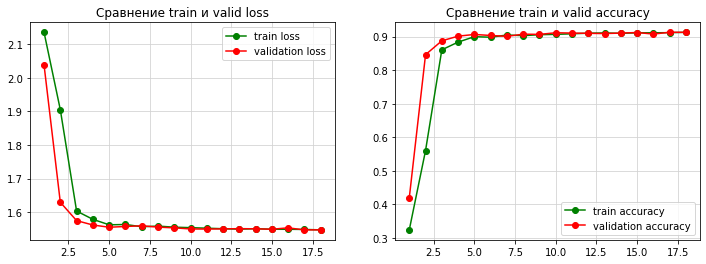

In [ ]:
graph(hist_md323_01)

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

88

In [ ]:
model_l = HPSearchNET(cnn_num=3, 
                    fc_num=2, 
                    kern_size=3, 
                    func_act='elu', 
                    nn_prn=True,
                    in_shape=160).to(device)

In [ ]:
model_l.load_state_dict(torch.load("/content/net/cifar_net_elu_cnn3_fc2_kr3.pth"))

<All keys matched successfully>

In [ ]:
model_loaded_test(model_l)

State_dict модели: 
	 conv1.weight :  torch.Size([16, 1, 3, 3])
	 conv1.bias :  torch.Size([16])
	 conv2.weight :  torch.Size([32, 16, 3, 3])
	 conv2.bias :  torch.Size([32])
	 conv3.weight :  torch.Size([64, 32, 3, 3])
	 conv3.bias :  torch.Size([64])
	 fc_dec1.weight :  torch.Size([6400, 25600])
	 fc_dec1.bias :  torch.Size([6400])
	 fc_out.weight :  torch.Size([10, 6400])
	 fc_out.bias :  torch.Size([10])
Модель - loss: 1.56017   accuracy: 90.158%   loss_val: 1.55651   accuracy_val: 90.530%


labels: tensor([7, 9, 7, 8, 9, 4, 6, 9, 0, 8, 7, 9, 5, 4, 0, 2, 0, 6, 9, 5, 7, 7, 2, 0,
        6, 9, 0, 7, 9, 9, 2, 9, 6, 6, 0, 6, 9, 9, 9, 4, 8, 3, 9, 2, 6, 4, 1, 8,
        8, 0, 3, 1, 8, 2, 9, 8, 1, 6, 6, 3, 6, 0, 5, 6])
predicted: tensor([7, 9, 7, 8, 9, 4, 6, 9, 0, 8, 7, 9, 6, 4, 0, 2, 0, 6, 9, 1, 7, 7, 2, 0,
        6, 9, 0, 7, 9, 9, 2, 9, 6, 6, 0, 6, 9, 9, 9, 4, 8, 3, 9, 2, 6, 4, 1, 8,
        8, 0, 3, 1, 8, 2, 9, 8, 1, 6, 6, 3, 6, 0, 2, 6], device='cuda:0')
correct: 61


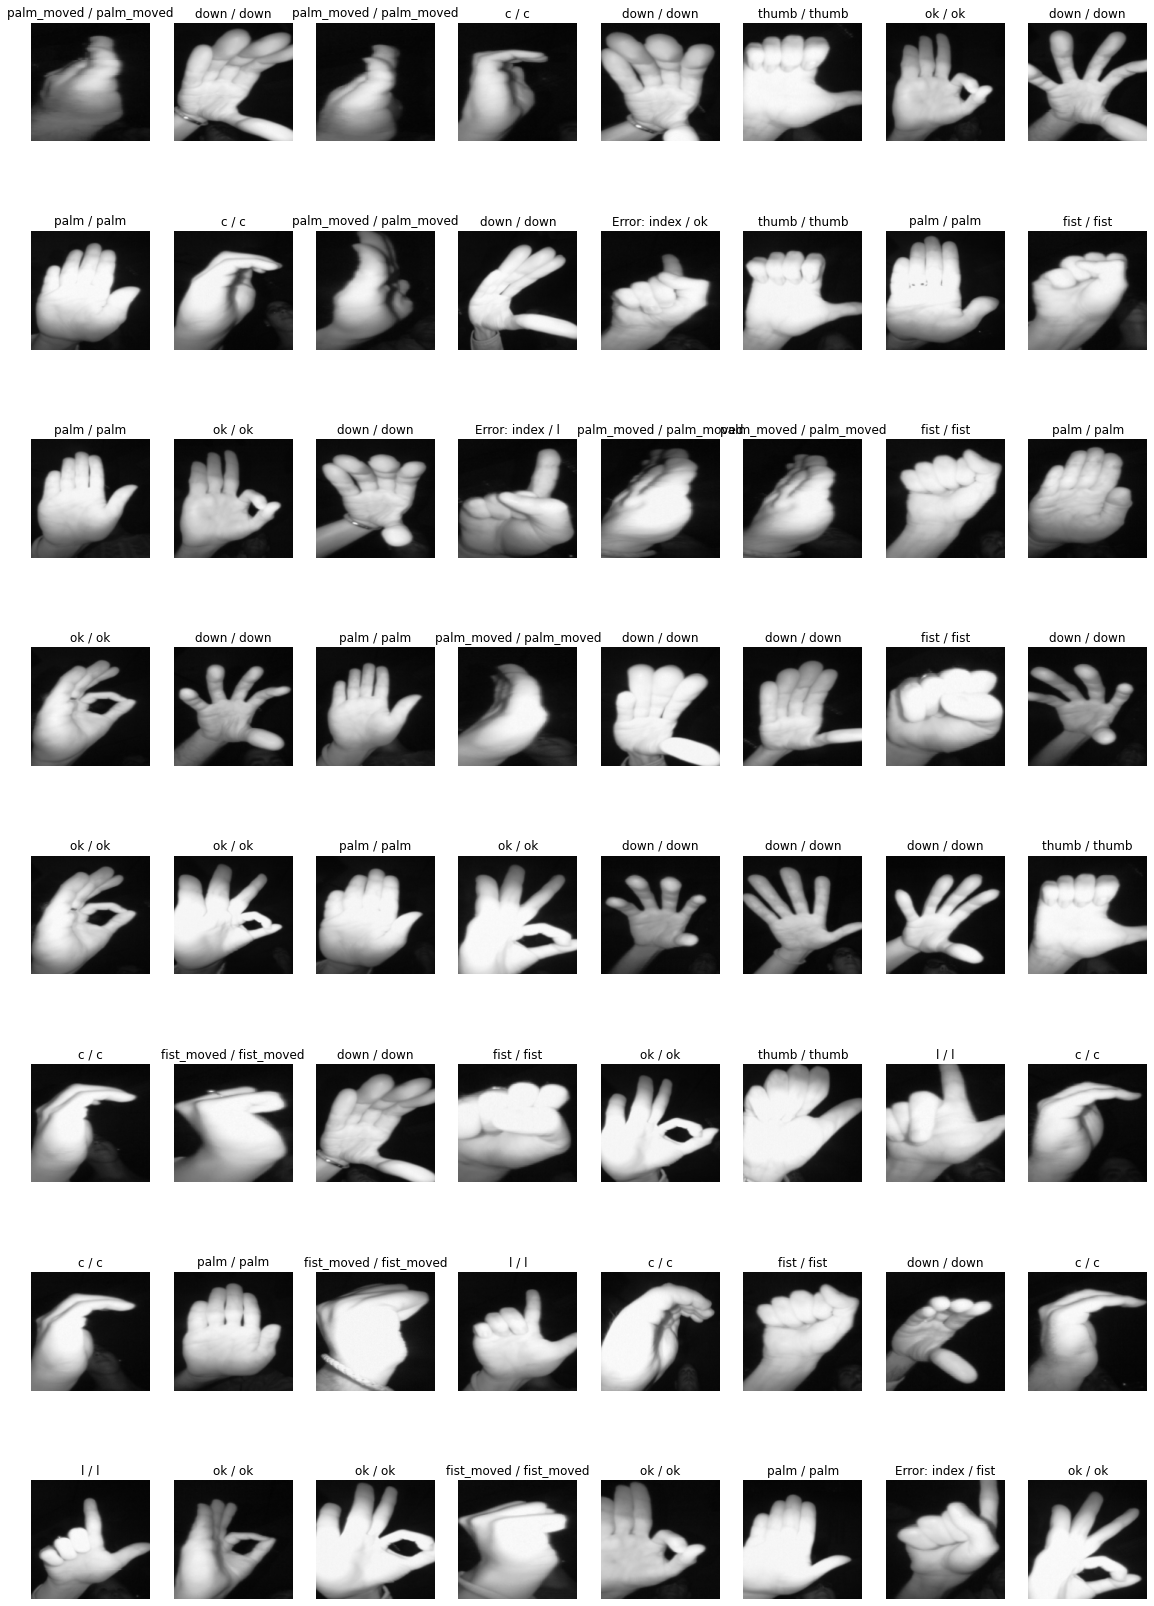

In [ ]:
data_iter = iter(valid_data_loader)
# [data_iter.next() for i in range(5)]

images, labels = data_iter.next()

print(f"labels: {labels}")

model.eval()
with torch.no_grad():
    inputs = images.to(device)
    labels = labels.to(device)

    outputs = model_l(inputs)
    # print(f"outputs: {outputs}")
    loss = criterion(outputs, labels)

    # Отслеживание точности
    total = labels.size(0)
    _, predicted = torch.max(outputs.data, 1)
    print(f"predicted: {predicted}")
    correct = (predicted == labels).sum().item()
    print(f"correct: {correct}")

plt.figure(figsize=(20, 30))
for ind in range(batch_s):
    ax = plt.subplot(8,8,ind+1)
    
    plt.imshow(cv2.cvtColor(images[ind, 0, :, :].numpy(), cv2.COLOR_GRAY2RGB))
    if int(labels[ind]) == int(predicted[ind]):
        plt.title(f"{class_names[int(labels[ind])]} / {class_names[int(predicted[ind])]}")
    else:
        plt.title(f"Error: {class_names[int(labels[ind])]} / {class_names[int(predicted[ind])]}")
    plt.axis('off')

In [ ]:
sample_data_loader = DataLoader(valid_data, batch_size=1, shuffle=True)

data_iter = iter(sample_data_loader)
# [data_iter.next() for i in range(5)]

image, label = data_iter.next()
label

tensor([9])

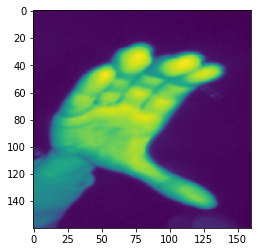

In [ ]:
plt.imshow(image[0, 0, :, :])

In [ ]:
model.eval()
with torch.no_grad():
    input = image.to(device)
    label = label.to(device)

    outputs = model_l(input)
    # print(f"outputs: {outputs}")
    loss = criterion(outputs, label)

    # Отслеживание точности
    total = label.size(0)
    _, predicted = torch.max(outputs.data, 1)
    print(f"predicted: {predicted}")
    correct = (predicted == label).sum().item()
    print(f"correct: {correct}")

predicted: tensor([9], device='cuda:0')
correct: 1
